In [1]:
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier

# Load the dataset
try:
    df = pd.read_csv("Health_Risk_Dataset.csv")
except FileNotFoundError:
    print("Error: Health_Risk_Dataset.csv not found.")
    exit()

print("Dataset loaded successfully. Here's the info:")
df.info()

print("\nFirst 5 rows of the dataset:")
print(df.head())

# --- 1. Preprocessing ---

# Drop Patient_ID as it's not a predictive feature
if 'Patient_ID' in df.columns:
    df = df.drop('Patient_ID', axis=1)

# One-Hot Encoding for 'Consciousness'
# Using pd.get_dummies
df = pd.get_dummies(df, columns=['Consciousness'], drop_first=True) # drop_first=True to avoid multicollinearity

# Label Encoding for the target variable 'Risk_Level'
# We need to define the order explicitly to ensure 0=Normal, 1=Low, etc.
risk_order = ['Normal', 'Low', 'Medium', 'High']
le = LabelEncoder()
le.fit(risk_order)
df['Risk_Level_Encoded'] = le.transform(df['Risk_Level'])

print(f"\nLabelEncoder classes (in order): {list(le.classes_)}")

# --- 2. Define Features (X) and Target (y) ---

# Define the target
y = df['Risk_Level_Encoded']

# Define the features (all columns except the original target and the new encoded target)
X = df.drop(['Risk_Level', 'Risk_Level_Encoded'], axis=1)

# **Crucial Step**: Save the column names and their order
# This is VITAL for the simulator to build a dataframe in the exact same format
model_columns = X.columns
joblib.dump(model_columns, 'model_columns.pkl')
print(f"\nModel features (columns) saved to 'model_columns.pkl'.")
print(f"Features being used: {list(model_columns)}")

# --- 3. Train/Test Split ---

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"\nData split into training ({X_train.shape[0]} samples) and testing ({X_test.shape[0]} samples).")

# --- 4. Model Training (The "Digital Oracle") ---

print("Training the RandomForest 'Digital Oracle'...")

# Initialize the RandomForestClassifier
oracle_model = RandomForestClassifier(
    n_estimators=100,  # A good default number of trees
    random_state=42
)

oracle_model.fit(X_train, y_train)
print("Model training complete.")

# --- 5. Model Evaluation ---

print("\n--- Model Evaluation ---")
# Make predictions on the test set
# Note: For the report, we need the final predicted class, not probabilities
y_pred = oracle_model.predict(X_test)

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy on Test Set: {accuracy * 100:.2f}%")

# Generate Classification Report
# We use le.classes_ to get the original string labels (Normal, Low, etc.)
report = classification_report(y_test, y_pred, target_names=le.classes_)
print("\nClassification Report:")
print(report)

# --- 6. Save the Model and Label Encoder ---

# Save the trained model
joblib.dump(oracle_model, 'digital_oracle_model.pkl')
print("\nTrained model saved as 'digital_oracle_model.pkl'")

# Save the Label Encoder
joblib.dump(le, 'le.pkl')
print("Label encoder saved as 'le.pkl'")

print("\n'Digital Oracle' build complete. All necessary files (model, columns, encoder) are saved.")

Dataset loaded successfully. Here's the info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Patient_ID         1000 non-null   object 
 1   Respiratory_Rate   1000 non-null   int64  
 2   Oxygen_Saturation  1000 non-null   int64  
 3   O2_Scale           1000 non-null   int64  
 4   Systolic_BP        1000 non-null   int64  
 5   Heart_Rate         1000 non-null   int64  
 6   Temperature        1000 non-null   float64
 7   Consciousness      1000 non-null   object 
 8   On_Oxygen          1000 non-null   int64  
 9   Risk_Level         1000 non-null   object 
dtypes: float64(1), int64(6), object(3)
memory usage: 78.3+ KB

First 5 rows of the dataset:
  Patient_ID  Respiratory_Rate  Oxygen_Saturation  O2_Scale  Systolic_BP  \
0      P0522                25                 96         1           97   
1      P0738               

Feature Importance calculated successfully.

Bar chart saved as 'feature_importance_bar_chart.png'.
Feature importance data saved to 'feature_importances.csv'.

Top 5 Most Important Features:
             Feature  Importance
4         Heart_Rate    0.209861
1  Oxygen_Saturation    0.205472
3        Systolic_BP    0.197895
0   Respiratory_Rate    0.183106
5        Temperature    0.157200
RandomForest model trained successfully for feature importance calculation.

Top 10 Feature Importances (What drives the risk prediction?):
             Feature  Importance
0         Heart_Rate    0.209861
1  Oxygen_Saturation    0.205472
2        Systolic_BP    0.197895
3   Respiratory_Rate    0.183106
4        Temperature    0.157200
5          On_Oxygen    0.027474
6           O2_Scale    0.011266
7    Consciousness_V    0.004803
8    Consciousness_P    0.001402
9    Consciousness_U    0.001340

Feature importance chart saved as 'feature_importance_bar_chart.png'.
Feature importances saved to 'featur

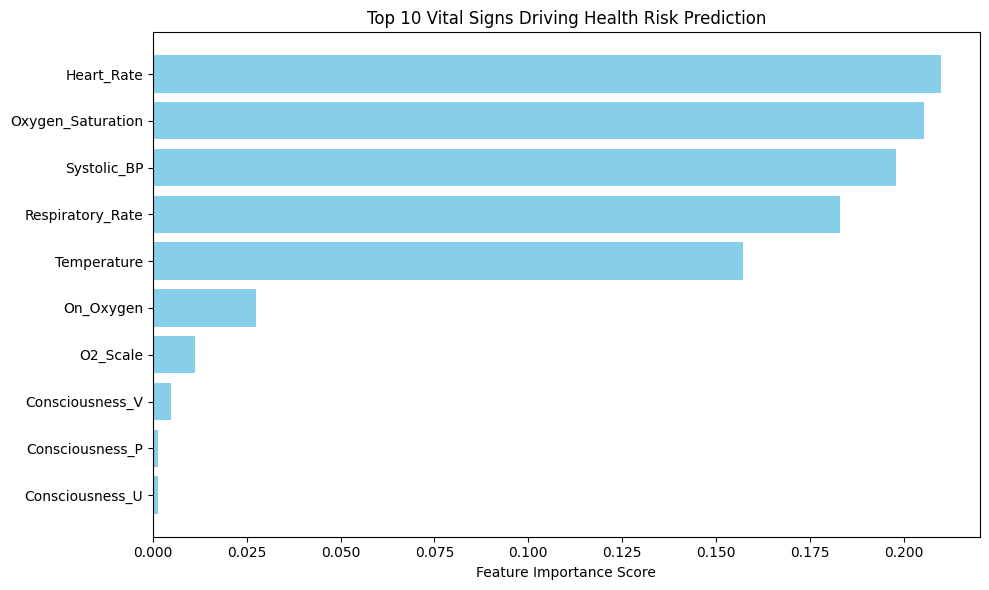

In [7]:
import matplotlib.pyplot as plt

# --- 1. Load Model Components ---
try:
    model = joblib.load('digital_oracle_model.pkl')
    model_columns = joblib.load('model_columns.pkl')
except FileNotFoundError:
    print("Error: Required model files ('digital_oracle_model.pkl' or 'model_columns.pkl') not found.")
    exit()

# --- 2. Extract Feature Importance ---
# RandomForestClassifier models have a feature_importances_ attribute
feature_importances = model.feature_importances_

# --- 3. Create and Sort DataFrame ---
importance_df = pd.DataFrame({
    'Feature': model_columns,
    'Importance': feature_importances
})

# Sort by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("Feature Importance calculated successfully.")

# --- 4. Visualize Results (Top 10) ---
plt.figure(figsize=(10, 6))
top_n = 10
plt.bar(importance_df['Feature'][:top_n], importance_df['Importance'][:top_n], color='teal')
plt.xlabel('Feature')
plt.ylabel('Importance Score (Gini)')
plt.title(f'Top {top_n} Feature Importances for Risk Prediction')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('feature_importance_bar_chart.png')
plt.close()

print("\nBar chart saved as 'feature_importance_bar_chart.png'.")

# --- 5. Save Results to CSV ---
importance_df.to_csv('feature_importances.csv', index=False)
print("Feature importance data saved to 'feature_importances.csv'.")
print("\nTop 5 Most Important Features:")
print(importance_df.head())

# --- 1. Load Data and Preprocessing (Re-training the Oracle) ---

df = pd.read_csv("Health_Risk_Dataset.csv")

# Drop Patient_ID
if 'Patient_ID' in df.columns:
    df = df.drop('Patient_ID', axis=1)

# One-Hot Encoding for 'Consciousness'
df = pd.get_dummies(df, columns=['Consciousness'], drop_first=True)

# Label Encoding for the target variable 'Risk_Level'
risk_order = ['Normal', 'Low', 'Medium', 'High']
le = LabelEncoder()
le.fit(risk_order)
df['Risk_Level_Encoded'] = le.transform(df['Risk_Level'])

# Define Features (X) and Target (y)
y = df['Risk_Level_Encoded']
X = df.drop(['Risk_Level', 'Risk_Level_Encoded'], axis=1)
model_columns = X.columns # Save column names again for safety

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize and Train the RandomForestClassifier (The Digital Oracle)
oracle_model = RandomForestClassifier(n_estimators=100, random_state=42)
oracle_model.fit(X_train, y_train)
print("RandomForest model trained successfully for feature importance calculation.")

# --- 2. Feature Importance Calculation and Visualization ---

# Extract importance scores
importances = oracle_model.feature_importances_
feature_names = model_columns

# Create a DataFrame for better handling and sorting
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Print the top features
print("\nTop 10 Feature Importances (What drives the risk prediction?):")
print(feature_importance_df.head(10))

# --- 3. Visualization ---

# Select the top 10 features for plotting
top_features = feature_importance_df.head(10)

plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'][::-1], top_features['Importance'][::-1], color='skyblue')
plt.xlabel("Feature Importance Score")
plt.title("Top 10 Vital Signs Driving Health Risk Prediction")
plt.tight_layout()

# Save the plot
plt.savefig('feature_importance_bar_chart.png')
print("\nFeature importance chart saved as 'feature_importance_bar_chart.png'.")

# Save the feature importance data to CSV (for reference)
feature_importance_df.to_csv('feature_importances.csv', index=False)
print("Feature importances saved to 'feature_importances.csv'.")

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=bdee0b07-dd93-46b8-8522-cce134092e71' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>